In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from xgboost import XGBClassifier
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image


2025-05-02 18:48:59.578634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746211739.767169      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746211739.823355      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
data_path = os.path.join('/kaggle/input/covidx-cxr2')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')
train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)


In [ ]:
val_data_path = os.path.join(data_path,'val')

val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)


In [ ]:
val_df.head()

,0,1,2,3
0,ANON196,CR.1.2.840.113564.1722810170.20200318082923328...,positive,actmed
1,ANON170,CR.1.2.840.113564.1722810170.20200320011259312...,positive,actmed
2,S03044,sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
3,S03044,sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
4,S03044,sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...,positive,bimcv


In [ ]:
train_df.head()

,0,1,2,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [ ]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)

In [ ]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df=val_df.rename(columns = {1:'image_name', 2:'diagnosis'})


In [ ]:
train_df.head()


,image_name,diagnosis
0,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative
1,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative
2,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative
3,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative
4,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative


In [ ]:
train_df.diagnosis.value_counts()

diagnosis
positive    57199
negative    10664
Name: count, dtype: int64

In [ ]:
val_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4232
Name: count, dtype: int64

In [ ]:
train_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [ ]:
train_df.duplicated().sum()

0

In [ ]:
val_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [ ]:
val_df.duplicated().sum()

0

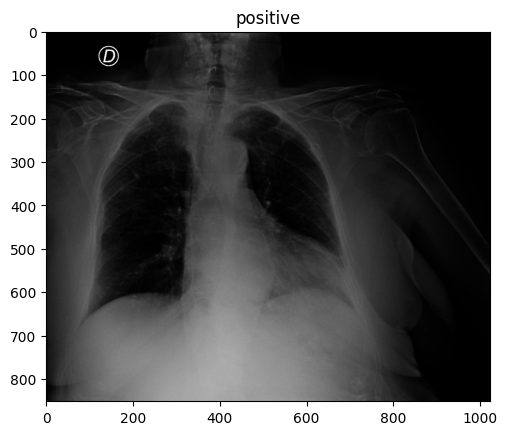

(852, 1024, 3)

In [ ]:
rand_indx = np.random.randint(0,len(train_df),1)[0]
img = cv2.imread(os.path.join(train_data_path, train_df.image_name[rand_indx]))
plt.imshow(img/255)
plt.title(train_df.diagnosis[rand_indx])
plt.show()
img.shape


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, df_test = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)

In [ ]:
df_majority = train_df[train_df['diagnosis'] == 'positive']
df_minority = train_df[train_df['diagnosis'] == 'negative']

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

train_df = pd.concat([df_majority, df_minority_upsampled])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
train_df.diagnosis.value_counts()

diagnosis
positive    45759
negative    45759
Name: count, dtype: int64

In [ ]:
df_test.diagnosis.value_counts()

diagnosis
positive    11440
negative     2133
Name: count, dtype: int64

In [ ]:
def custom_preprocess(img):
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.bitwise_and(img, mask)

    return img.astype(np.float32) / 255.0


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15, zoom_range=0.1, horizontal_flip=True,
    width_shift_range=0.05, height_shift_range=0.05
).flow_from_dataframe(
    dataframe=train_df, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=val_df, directory=val_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)

Found 91518 validated image filenames belonging to 2 classes.
Found 8473 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU

def pepx_module(x, filter1, filter2, filter3, filter4):
    # First projection
    x = Conv2D(filter1, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Expansion
    x = Conv2D(filter2, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Depthwise convolution
    x = DepthwiseConv2D((3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second projection
    x = Conv2D(filter3, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Extension
    x = Conv2D(filter4, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x


In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def build_covidnet(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(56, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Downsample
    # x = Conv2D(56, (1, 1), padding='same')(x)
    # x = BatchNormalization()(x)
    # x = ReLU()(x)

    # PEPX 1.1,1.2,1.3
    x = pepx_module(x, 28, 56, 28, 56)
    x = pepx_module(x, 28, 56, 28, 56)
    x = pepx_module(x, 28, 56, 28, 56)
    # PEPX 2.1,2.2,2.3,2.4
    x = pepx_module(x, 56, 112, 56, 112)
    x = pepx_module(x, 56, 112, 56, 112)
    x = pepx_module(x, 56, 112, 56, 112)
    x = pepx_module(x, 56, 112, 56, 112)
     # PEPX 3.1,3.2,3.3,3.4,3.5,3.6
    x = pepx_module(x, 112, 224, 112, 224)
    x = pepx_module(x, 112, 224, 112, 224)
    x = pepx_module(x, 112, 224, 112, 224)
    x = pepx_module(x, 112, 224, 112, 224)
    x = pepx_module(x, 112, 224, 112, 224)
    x = pepx_module(x, 112, 224, 112, 224)
     # PEPX 4.1,4.2
    x = pepx_module(x, 224, 424, 224, 424)
    x = pepx_module(x, 224, 424, 224, 424)
    # PEPX 4.3 → 400 channels
    x = pepx_module(x, 224, 424, 224, 400)

    # Global pooling and classification
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    return model

# Compile
model = build_covidnet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[early_stopping]
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746212089.045143      96 service.cc:148] XLA service 0x781d981559f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746212089.046027      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746212091.025468      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746212102.376087      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2547s 877ms/step - accuracy: 0.8188 - loss: 0.4158 - val_accuracy: 0.5220 - val_loss: 1.6609
Epoch 2/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2286s 797ms/step - accuracy: 0.8834 - loss: 0.3133 - val_accuracy: 0.8069 - val_loss: 0.5793
Epoch 3/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2129s 743ms/step - accuracy: 0.8900 - loss: 0.2958 - val_accuracy: 0.5522 - val_loss: 2.1866
Epoch 4/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2178s 760ms/step - accuracy: 0.8973 - loss: 0.2781 - val_accuracy: 0.6615 - val_loss: 0.6950
Epoch 5/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2207s 770ms/step - accuracy: 0.8986 - loss: 0.2735 - val_accuracy: 0.9038 - val_loss: 0.2609


In [ ]:
test_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=df_test, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)

Found 13573 validated image filenames belonging to 2 classes.


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
y_test = test_gen.classes
y_proba_test = model.predict(test_gen, verbose=1)
y_pred_test = (y_proba_test > 0.5).astype(int)
print("\nVGG19 Test Results:")
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test,y_pred_test))
print("AUC Score:", roc_auc_score(y_test,y_proba_test))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


425/425 ━━━━━━━━━━━━━━━━━━━━ 267s 623ms/step

VGG19 Test Results:
              precision    recall  f1-score   support

           0       0.58      0.91      0.71      2133
           1       0.98      0.88      0.93     11440

    accuracy                           0.88     13573
   macro avg       0.78      0.89      0.82     13573
weighted avg       0.92      0.88      0.89     13573

Accuracy: 0.883003020702866
AUC Score: 0.9547925702988994


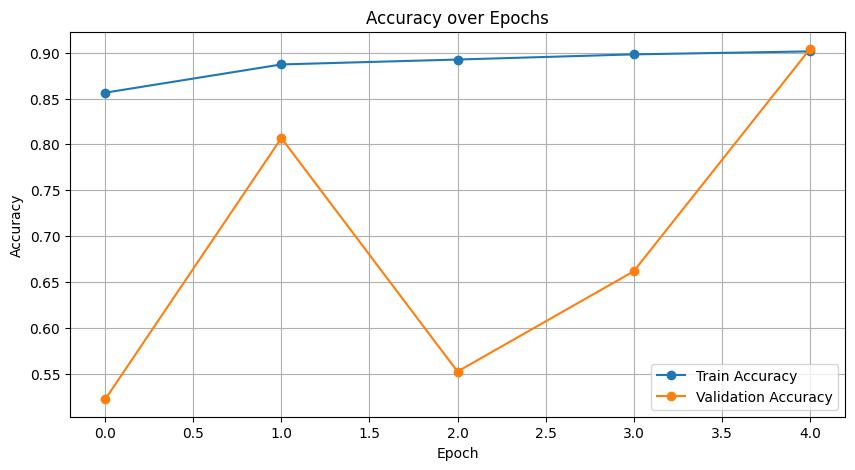

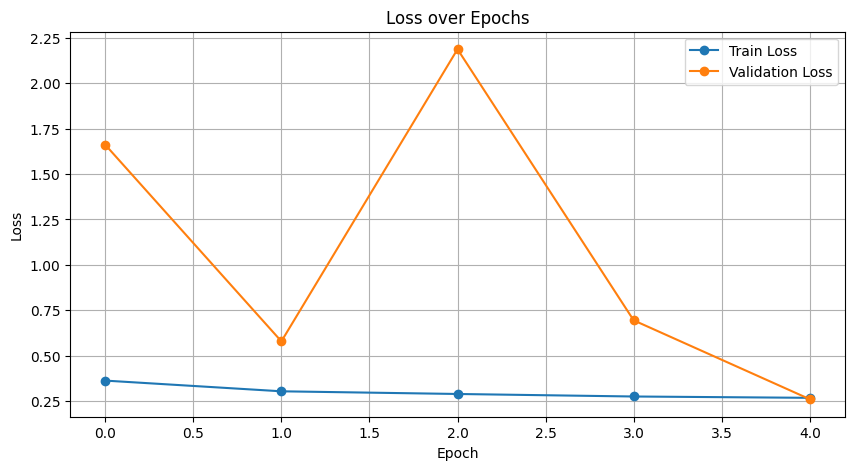

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


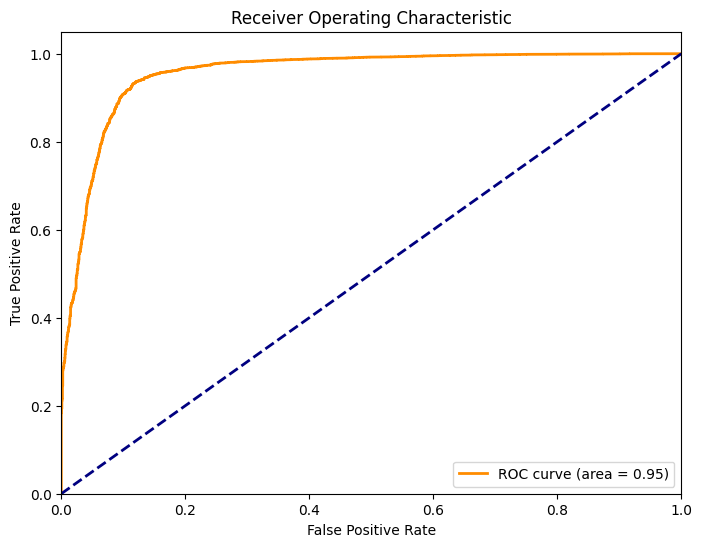

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


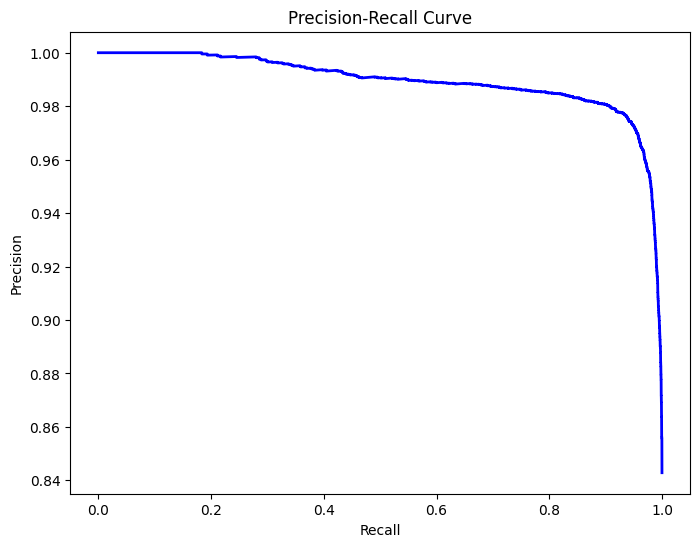

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


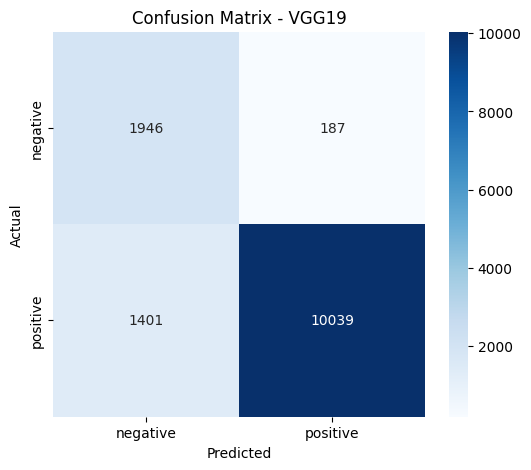

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
class_labels = ['negative', 'positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - VGG19')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
pip install lime


Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

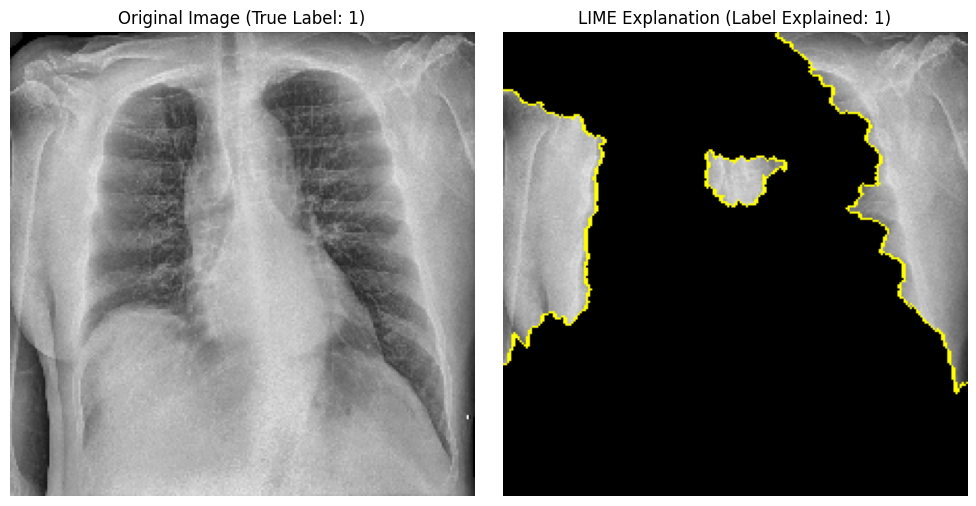

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model Prediction: Class 0 = 0.0482, Class 1 = 0.9518


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.models import load_model  # optional if loading
import tensorflow as tf

# Preprocessing function (normalize)
def custom_preprocess(img):
    return img / 255.0

# Prediction function for LIME — return class 0 and class 1 probabilities
def predict_fn(images):
    processed_images = np.array([custom_preprocess(img) for img in images])
    preds = model.predict(processed_images)
    return np.concatenate([1 - preds, preds], axis=1)  # [[class_0, class_1], ...]

# Get an image from the test generator
idx = 0
img_batch, label_batch = test_gen[idx]
img = img_batch[0]
true_label = int(label_batch[0])

# If grayscale, convert to 3-channel RGB
if img.shape[-1] == 1:
    img = np.repeat(img, 3, axis=-1)

# Convert image to uint8 for LIME
img_for_lime = (img * 255).astype(np.uint8)

# Create LIME explainer
explainer = lime_image.LimeImageExplainer()

# Run explanation
explanation = explainer.explain_instance(
    image=img_for_lime,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Get explanation mask for the **true label**
temp, mask = explanation.get_image_and_mask(
    label=true_label,  # <--- force explanation for the true label
    positive_only=True,
    num_features=5,
    hide_rest=True
)

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original Image (True Label: {true_label})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation (Label Explained: {true_label})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: print model's prediction
probs = predict_fn(np.expand_dims(img_for_lime, axis=0))
print(f"Model Prediction: Class 0 = {probs[0][0]:.4f}, Class 1 = {probs[0][1]:.4f}")


In [ ]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)


conv2d_96
conv2d_97
conv2d_98
conv2d_99
conv2d_100
conv2d_101
conv2d_102
conv2d_103
conv2d_104
conv2d_105
conv2d_106
conv2d_107
conv2d_108
conv2d_109
conv2d_110
conv2d_111
conv2d_112
conv2d_113


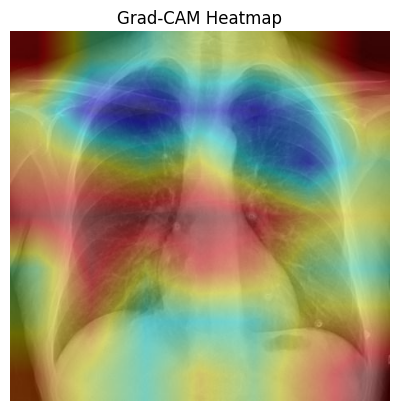

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_max(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, (224, 224))
    return np.expand_dims(img_resized, axis=0)

def run_gradcam(img_path, model, last_conv_layer_name):
    img_array = load_and_preprocess_image(img_path)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    original_img = cv2.imread(img_path)
    overlay = overlay_heatmap(heatmap, original_img)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()

img_path = "/kaggle/input/covidx-cxr2/train/000001-3.jpg"
last_conv_layer_name = "conv2d_113"
run_gradcam(img_path, model, last_conv_layer_name)
